2024-12-13 02:44:00.611358: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Activities with >80% False motion_value:
PID: P06, Activity: FFSIT, Proportion of False: 1.00
PID: P11, Activity: FFSIT, Proportion of False: 0.96


/var/folders/xt/j055vd5n66x6nhkm2f0zzg2w0000gn/T/ipykernel_64507/4084912460.py:235: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='count', data=class_counts, palette=['skyblue', 'salmon'])


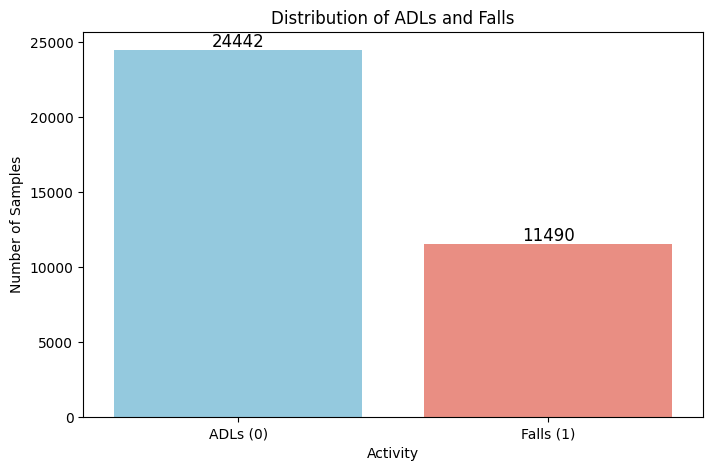

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, LSTM, Dense, Dropout, MaxPooling1D, Flatten
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import ADASYN

plt.style.use('default')

def plot_performance(history):
    # plot training & validation accuracy values
    plt.figure(figsize=(12, 5))

    # accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
def remove_zero_readings(df, threshold=10):
    """Remove records with zero readings above threshold."""
    # Track problematic sensor combinations
    zero_readings = pd.DataFrame()
    for sensor in ['breathingRate', 'heartRate']:
        zero_counts = df[df[sensor] == 0.0].groupby(['PID', 'activity_name'])[sensor].count()
        zero_readings = pd.concat([zero_readings, zero_counts[zero_counts > threshold]])
    
    # Remove identified problematic records
    outlier_indices = zero_readings.index.drop_duplicates()
    return df[~df.set_index(['PID', 'activity_name']).index.isin(outlier_indices)]


df = pd.read_csv("combined_sensor_data-all-7.csv")

# ignore one hot encoded and netatmo and static 
# health_idx_columns = ['health_idx_0', 'health_idx_1', 'health_idx_2', 'health_idx_3', 'health_idx_4']
# physiologicalState_columns = ['physiologicalState_0', 'physiologicalState_1', 'physiologicalState_2','physiologicalState_3', 'physiologicalState_4']
# df = df.drop(['targetDistance','CO2','Humidity','Noise','Pressure','AbsolutePressure',
            #   'age','gender','height','weight','fitness_level'] + physiologicalState_columns + health_idx_columns, axis=1)

# remove redundant 
df = df.drop(['targetDistance', 'AbsolutePressure'], axis=1)

# feature engineering 
def combine_ambient(df, ambient_features):
    # Step 1: Select only ambient sensor features (CO2, Humidity, Noise, Pressure)
    ambient_df = df[ambient_features]

    # Step 2: Handle NaN values by filling with the mean
    ambient_df = ambient_df.fillna(ambient_df.mean())

    # Step 3: Standardize the ambient sensor features
    scaler = StandardScaler()
    ambient_features_scaled = scaler.fit_transform(ambient_df)
    # Step 4: Apply PCA to create the Environmental Index
    pca = PCA(n_components=1)  # Aggregate into a single component
    env_index = pca.fit_transform(ambient_features_scaled)
    # Add the Environmental Index to the original DataFrame
    df['environmental_index'] = env_index
    # Display the updated DataFrame
    # df.drop(ambient_features)
    # print(df.columns)
    df = df.drop(ambient_features, axis=1)
    return df


# Define the activities
fall_activities = ["FFAS", "FFT", "FWW", "FFTSIT", "FHO", "FFSIT"]
non_fall_activities = ["LOB", "RS", "SBS", "SIT", "SSS", 'SSW', "SWW", "TWC", "WAT", 'WSS']
ambient_features = ['CO2', 'Humidity', 'Noise', 'Pressure']

def remove_low_motion_activities(df, threshold=0.8):
    """
    Print and remove fall activities where motion_value is False 
    for more than the threshold percentage of the activity's duration.
    """
    # List of fall activities to check
    fall_activities = ["FFAS", "FFT", "FWW", "FFTSIT", "FHO", "FFSIT"]

    # Filter for fall activities only
    falls_df = df[df['activity_name'].isin(fall_activities)]

    # Calculate percentage of False motion values for each (PID, activity_name)
    motion_stats = (
        falls_df.groupby(['PID', 'activity_name'])['motion_value']
        .apply(lambda x: (x == False).mean())  # Calculate proportion of False values
    )

    # Identify activities to print and remove based on the threshold
    activities_to_remove = motion_stats[motion_stats > threshold]

    # Print the activity names and their proportions before removing
    print("Activities with >80% False motion_value:")
    for (pid, activity_name), proportion in activities_to_remove.items():
        print(f"PID: {pid}, Activity: {activity_name}, Proportion of False: {proportion:.2f}")

    # Remove identified activities from the DataFrame
    return df[~df.set_index(['PID', 'activity_name']).index.isin(activities_to_remove.index)]

def identify_and_remove_outliers_combined(df):
    """
    Identify outliers for both ADL and Fall activities using IQR and remove them from the dataset.
    Retain all other information and merge cleaned activities back.
    """
    # Group by base_activity, class, and PID to calculate the duration per activity
    duration_counts = df.groupby(['base_activity', 'class', 'PID']).size().reset_index(name='duration')

    # Separate ADLs and Falls
    adls = duration_counts[duration_counts['class'] == 0]  # ADL activities
    falls = duration_counts[duration_counts['class'] == 1]  # Fall activities

    # Helper function to identify and clean outliers using IQR
    def clean_outliers(data):
        outliers = []
        cleaned_data = []

        for activity in data['base_activity'].unique():
            activity_data = data[data['base_activity'] == activity]
            Q1 = activity_data['duration'].quantile(0.25)
            Q3 = activity_data['duration'].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Identify outliers and non-outliers
            activity_outliers = activity_data[
                (activity_data['duration'] < lower_bound) | (activity_data['duration'] > upper_bound)
            ]
            activity_cleaned = activity_data[
                (activity_data['duration'] >= lower_bound) & (activity_data['duration'] <= upper_bound)
            ]

            outliers.append(activity_outliers)
            cleaned_data.append(activity_cleaned)

        # Combine all outliers and cleaned data
        all_outliers = pd.concat(outliers, ignore_index=True)
        all_cleaned_data = pd.concat(cleaned_data, ignore_index=True)

        return all_outliers, all_cleaned_data

    # Clean outliers for ADLs and Falls separately
    adl_outliers, cleaned_adls = clean_outliers(adls)
    fall_outliers, cleaned_falls = clean_outliers(falls)

    # Print identified outliers
    print("\nIdentified ADL Outliers:")
    print(adl_outliers[['base_activity', 'PID', 'duration']])

    print("\nIdentified Fall Outliers:")
    print(fall_outliers[['base_activity', 'PID', 'duration']])

    # Combine cleaned ADLs and Falls
    cleaned_df = pd.concat([cleaned_adls, cleaned_falls], ignore_index=True)

    # Merge cleaned activities with the original DataFrame to retain all columns
    final_df = df.merge(cleaned_df[['base_activity', 'PID']], on=['base_activity', 'PID'], how='inner')

    return final_df


# 2. Apply cleaning steps
df = remove_zero_readings(df)
df['motion_value'] = df['motion_value'].astype(int)
df = remove_low_motion_activities(df)
# df_2 = identify_and_remove_outliers_combined(df)

df_clean = df.drop(ambient_features, axis=1)
df_ambient = combine_ambient(df, ambient_features)

def filter_activities(df):
    # Define relevant fall activities
    fall_activities = ["FFAS", "FFT", "FWW", "FFTSIT", "FHO", "FFSIT"]

    # Define unique non-fall (ADL) activities (after removing trailing digits)
   
    # non_fall_activities = [
    #     "LOB", "RS", "SBS", "SIT", 'SSW', "SWW", "TWC", "WAT"
    # ]

    non_fall_activities = [
            "LOB", "RS", "SBS", 
            "SWW", "TWC", "WAT", 
            'WSS', 'SSW', 'SSS'
        ]

    # Filter the dataset to keep only relevant activities
    df_filtered = df[df['base_activity'].isin(fall_activities + non_fall_activities)]
    return df_filtered

final_df_clean = filter_activities(df_clean)
final_df_ambient = filter_activities(df_ambient)

def plot_class_distribution(df):
    """
    Plot the distribution of ADLs (class=0) and Falls (class=1) with sample counts.
    """
    # Get the class distribution
    class_counts = df['class'].value_counts().reset_index()
    class_counts.columns = ['class', 'count']
    class_counts['label'] = class_counts['class'].apply(lambda x: 'ADLs (0)' if x == 0 else 'Falls (1)')

    # Plot the distribution using a bar plot
    plt.figure(figsize=(8, 5))
    sns.barplot(x='label', y='count', data=class_counts, palette=['skyblue', 'salmon'])

    # Add labels on top of the bars
    for index, row in class_counts.iterrows():
        plt.text(index, row['count'], f'{row["count"]}', ha='center', va='bottom', fontsize=12)

    # Add plot labels and title
    plt.title("Distribution of ADLs and Falls")
    plt.xlabel("Activity")
    plt.ylabel("Number of Samples")
    plt.show()

plot_class_distribution(final_df_ambient)

# final_df
# 19195/10583
# print(len(final_df_clean.columns)) # 14 features
# print(final_df_clean.columns) # 14 features
# print(final_df_ambient.columns) # 14 features
# print(df_clean.columns) # 14 features with all ADLs

# print(df_clean.shape)
# print(final_df_clean.shape)

# Start preprocessing for LSTM

In [9]:
import tensorflow as tf 

def build_lstm_model_l2(input_shape, optimizer='adam', units=64, learning_rate=0.001, l2_lambda=0.00001):
    model = Sequential([
        tf.keras.Input(shape=input_shape),
        LSTM(units, activation='tanh', return_sequences=False,
             kernel_regularizer=l2(l2_lambda),
             recurrent_regularizer=l2(l2_lambda),
             bias_regularizer=l2(l2_lambda)),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_lstm_model_2(input_shape, optimizer='adam', units=128, learning_rate=0.001, l2_lambda=0.00001):
    model = Sequential([
        tf.keras.Input(shape=input_shape),
        LSTM(units, activation='tanh', return_sequences=False,
             kernel_regularizer=l2(l2_lambda),
             recurrent_regularizer=l2(l2_lambda),
             bias_regularizer=l2(l2_lambda)),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_lstm_model_3(input_shape, optimizer='adam', units=256, learning_rate=0.001, l2_lambda=0.00001):
    model = Sequential([
        tf.keras.Input(shape=input_shape),
        LSTM(units, activation='tanh', return_sequences=False,
             kernel_regularizer=l2(l2_lambda),
             recurrent_regularizer=l2(l2_lambda),
             bias_regularizer=l2(l2_lambda)),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_lstm_model_4(input_shape, optimizer='adam', units=256, learning_rate=0.001, l2_lambda=0.0001):
    model = Sequential([
        tf.keras.Input(shape=input_shape),
        LSTM(units, activation='tanh', return_sequences=False,
             kernel_regularizer=l2(l2_lambda),
             recurrent_regularizer=l2(l2_lambda),
             bias_regularizer=l2(l2_lambda)),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# def build_lstm_model_5(input_shape, optimizer='rmsprop', units=16, l2_lambda=0.00001):
    # # https://github.com/YJZFlora/Fall_Detection_Deep_Learning_Model/blob/master/Training_code/model_training_May08.ipynb
    # lstm_model = Sequential()
    # lstm_model.add(LSTM(16, 
    #                 input_shape=input_shape,
    #                 return_sequences=True))
    # lstm_model.add(LSTM(16, ))
    # lstm_model.add(layers.Dense(1, activation='sigmoid'))
    # if optimizer == 'adam':
    #     opt = Adam(learning_rate=learning_rate)
    # elif optimizer == 'rmsprop':
    #     opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    
    # lstm_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'], metrics.AUC(), metrics.Recall())
    # return lstm_model


# without regularisation, 256 units 
# def build_lstm_model_4(input_shape, optimizer='adam', units=256, learning_rate=0.001):
#     model = Sequential([
#         tf.keras.Input(shape=input_shape),
#         LSTM(units, activation='tanh'),
#         Dense(64, activation='relu'),
#         Dense(1, activation='sigmoid')
#     ])

#     if optimizer == 'adam':
#         opt = Adam(learning_rate=learning_rate)
#     elif optimizer == 'rmsprop':
#         opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

#     model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
#     return model

In [7]:
from sklearn.metrics import classification_report
import tensorflow.keras.backend as K
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from imblearn.over_sampling import ADASYN
from typing import Tuple
from imblearn.over_sampling import RandomOverSampler

plt.style.use('default')

def plot_advanced_metrics(y_test, y_pred_probs, model_name="CNN Model"):
    """
    Create publication-quality ROC and Precision-Recall curves
    """
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
    roc_auc = auc(fpr, tpr)
    
    ax1.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
             label='Random classifier')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title(f'{model_name} ROC Curve')
    ax1.legend(loc="lower right")
    ax1.grid(True)
    
    # 2. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
    avg_precision = average_precision_score(y_test, y_pred_probs)
    
    ax2.plot(recall, precision, color='darkgreen', lw=2,
             label=f'PR curve (AP = {avg_precision:.3f})')
    ax2.axhline(y=np.sum(y_test)/len(y_test), color='navy', lw=2, linestyle='--',
                label='Random classifier')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title(f'{model_name} Precision-Recall Curve')
    ax2.legend(loc="lower left")
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    # plt.tight_layout()
    # plt.savefig('advanced_metrics.png', dpi=300, bbox_inches='tight')
    # plt.close()
    
    return roc_auc, avg_precision

def analyze_threshold_impact(y_test, y_pred_probs):
    """
    Analyze impact of different classification thresholds using numpy operations
    """
    thresholds = np.arange(0.1, 1.0, 0.1)
    results = []
    
    for threshold in thresholds:
        y_pred = (y_pred_probs >= threshold).astype(int)
        
        # Calculate confusion matrix elements using numpy
        tn = np.sum(np.logical_and(y_test == 0, y_pred == 0))
        fp = np.sum(np.logical_and(y_test == 0, y_pred == 1))
        fn = np.sum(np.logical_and(y_test == 1, y_pred == 0))
        tp = np.sum(np.logical_and(y_test == 1, y_pred == 1))
        
        # Calculate metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        results.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })
    
    # Plot threshold impact
    plt.figure(figsize=(10, 6))
    thresholds = [r['threshold'] for r in results]
    plt.plot(thresholds, [r['precision'] for r in results], 
             label='Precision', marker='o')
    plt.plot(thresholds, [r['recall'] for r in results], 
             label='Recall', marker='s')
    plt.plot(thresholds, [r['f1'] for r in results], 
             label='F1-score', marker='^')
    plt.xlabel('Classification Threshold')
    plt.ylabel('Score')
    plt.title('Impact of Classification Threshold on Metrics')
    plt.legend()
    plt.grid(True)
    plt.show()
    # plt.tight_layout()
    # plt.savefig('threshold_analysis.png', dpi=300, bbox_inches='tight')
    # plt.close()
    
    return results

def find_optimal_threshold(results):
    """Find threshold with highest F1 score"""
    return max(results, key=lambda x: x['f1'])['threshold']

def format_threshold_results(results):
    """Format threshold results as string"""
    text = ""
    for r in results:
        text += f"\n   Threshold {r['threshold']:.1f}:"
        text += f" Precision={r['precision']:.3f},"
        text += f" Recall={r['recall']:.3f},"
        text += f" F1={r['f1']:.3f}"
    return text

def evaluate_model_advanced(model, X_test, y_test):
    """
    Main function to generate all advanced metrics
    """
    # Get predictions and ensure they're the right shape
    y_pred_probs = model.predict(X_test, verbose=0)
    if len(y_pred_probs.shape) > 1 and y_pred_probs.shape[1] == 1:
        y_pred_probs = y_pred_probs.ravel()
    
    # Generate ROC and PR curves
    roc_auc, avg_precision = plot_advanced_metrics(y_test, y_pred_probs)
    
    # Analyze threshold impact
    threshold_results = analyze_threshold_impact(y_test, y_pred_probs)
    
    # Generate summary
    summary = f"""
    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): {roc_auc:.4f}

    2. Precision-Recall Analysis:
    - Average Precision (AP): {avg_precision:.4f}

    3. Threshold Analysis:
    Optimal threshold based on F1-score: {find_optimal_threshold(threshold_results):.2f}
    
    Performance at different thresholds:
    {format_threshold_results(threshold_results)}
    """
    
    print(summary)
    return roc_auc, avg_precision, threshold_results



def print_window_dataset_info(X, y, stage=""):
    """
    Print detailed information about windowed dataset
    """
    print(f"\n{'='*20} {stage} {'='*20}")
    print(f"Dataset shape: {X.shape}")  # (n_samples, window_size, n_features)
    print(f"Labels shape: {y.shape}")   # (n_samples,)
    
    # Class distribution
    unique, counts = np.unique(y, return_counts=True)
    total_samples = len(y)
    
    print("\nClass Distribution:")
    print("-----------------")
    for class_label, count in zip(unique, counts):
        percentage = (count / total_samples) * 100
        print(f"Class {class_label}: {count} samples ({percentage:.2f}%)")


def create_sliding_windows_normal(data, window_size=8, step_size=1):
    """Create sliding windows across the entire dataset without grouping."""
    windows = []
    labels = []
    features_df = data.drop(['timestamp', 'class', 'activity_name', 'base_activity', 'PID'], axis=1)

    # Iterate through the dataset to create sliding windows
    for i in range(0, len(features_df) - window_size + 1, step_size):
        # Extract a window of features and normalize it
        window = features_df.iloc[i:i + window_size].values
        normalized_window = normalize_window(window)

        # Store the normalized window and corresponding label (from 'class' column)
        windows.append(normalized_window)
        labels.append(data['class'].iloc[i + window_size - 1])  # Label corresponds to the last row in the window

    return np.array(windows), np.array(labels)


# new
def create_sliding_windows2(data, window_size=8, step_size=1):
    """Create sliding windows within each activity, ensuring activities are not mixed."""
    windows = []
    labels = []

    # Extract feature columns and ensure they are numeric
    features_df = data.drop(['timestamp', 'class', 'activity_name', 'base_activity', 'PID'], axis=1)

    # Group by participant and activity to maintain boundaries
    for _, group in data.groupby(['PID', 'activity_name']):
        group = group.reset_index(drop=True)

        # Handle any NaN values resulting from coercion
        group = group.fillna(0)  # Replace NaN values with 0 or use other imputation methods

        # Only process windows of the desired size
        for i in range(0, len(group) - window_size + 1, step_size):
            window = group.iloc[i:i + window_size]

            # Normalize the window
            normalized_window = normalize_window(window[features_df.columns].values)

            windows.append(normalized_window)
            labels.append(window['class'].mode()[0])  # Assign the most frequent class in the window

    return np.array(windows), np.array(labels)


def normalize_window(window):
    """Normalize each sliding window independently (channel-wise)."""
    epsilon = 1e-10  # To prevent division by zero
    mean = window.mean(axis=0)  # Mean per feature
    std = window.std(axis=0)  # Std per feature
    return (window - mean) / (std + epsilon)


def apply_ros(X_train, y_train):
    """
    Apply Random OverSampling (ROS) to balance the dataset.
    """
    ros = RandomOverSampler(random_state=42)
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)  # Reshape for ROS
    X_resampled, y_resampled = ros.fit_resample(X_train_reshaped, y_train)
    print(f"Data after ROS: {X_resampled.shape[0]} samples")
    return X_resampled.reshape(-1, X_train.shape[1], X_train.shape[2]), y_resampled

def apply_smote(X_train, y_train):
    smote = SMOTE(random_state=42)
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
    X_resampled, y_resampled = smote.fit_resample(X_train_reshaped, y_train)
    print(f"Data after SMOTE: {X_resampled.shape[0]} samples")

    return X_resampled.reshape(-1, X_train.shape[1], X_train.shape[2]), y_resampled

def apply_adasyn(X_train, y_train):
    adasyn = ADASYN(random_state=42)
    # Reshape the data for ADASYN (flatten each sample into 2D for the algorithm)
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
    X_resampled, y_resampled = adasyn.fit_resample(X_train_reshaped, y_train)
    
    print(f"Data after ADASYN: {X_resampled.shape[0]} samples")
    
    # Reshape back to the original shape of X_train
    return X_resampled.reshape(-1, X_train.shape[1], X_train.shape[2]), y_resampled


def apply_mu_sigma(X_train: np.ndarray, y_train: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Augments training data using Mu-Sigma augmentation technique.
    Doubles the training data by creating synthetic signals with added/subtracted noise.
    
    Args:
        X_train (np.ndarray): Training data of shape (n_samples, n_timesteps[, n_features])
        y_train (np.ndarray): Training labels
    Returns:
        Tuple[np.ndarray, np.ndarray]: Augmented training data and corresponding labels
    """
    # Generate noise for each sample in training data
    noise = np.zeros_like(X_train)
    
    # Calculate noise for each sample independently
    for i in range(len(X_train)):
        # Calculate standard deviation of current sample
        sigma = np.std(X_train[i])
        # Generate noise with zero mean and sample's standard deviation
        noise[i] = np.random.normal(loc=0, scale=sigma, size=X_train[i].shape)
    
    # Create augmented samples
    X_plus_noise = X_train + noise
    X_minus_noise = X_train - noise
    
    # Combine original and augmented data
    X_augmented = np.vstack((X_train, X_plus_noise, X_minus_noise))
    y_augmented = np.concatenate((y_train, y_train, y_train))
    
    # Shuffle the augmented dataset
    shuffle_idx = np.random.permutation(len(X_augmented))
    X_augmented = X_augmented[shuffle_idx]
    y_augmented = y_augmented[shuffle_idx]
    
    return X_augmented, y_augmented

def apply_gan_augmentation(X_train, y_train, num_samples=8618, noise_dim=100, hidden_dim=64, num_epochs=500):
    """
    Generate synthetic time-series data using a GAN and augment the training set.
    
    Parameters:
    - X_train: Original training data (features)
    - y_train: Original training labels
    - num_samples: Number of synthetic sequences to generate
    - noise_dim: Dimensionality of the random noise vector
    - hidden_dim: Hidden layer size for both Generator and Discriminator
    - num_epochs: Number of epochs to train the GAN
    
    Returns:
    - X_augmented: Augmented feature set (X_train + synthetic samples)
    - y_augmented: Augmented labels set (y_train + synthetic labels)
    """

    # Get sequence length from X_train (assume [n_samples, seq_len, features])
    seq_len = X_train.shape[1]
    feature_dim = X_train.shape[2]

    # Define the Generator
    class Generator(nn.Module):
        def __init__(self, noise_dim, hidden_dim, output_dim):
            super(Generator, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(noise_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, output_dim)
            )

        def forward(self, noise):
            return self.model(noise)

    # Define the Discriminator
    class Discriminator(nn.Module):
        def __init__(self, input_dim, hidden_dim):
            super(Discriminator, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.LeakyReLU(0.2),
                nn.Linear(hidden_dim, 1),
                nn.Sigmoid()
            )

        def forward(self, data):
            return self.model(data)

    # Initialize the Generator and Discriminator
    generator = Generator(noise_dim, hidden_dim, seq_len * feature_dim)
    discriminator = Discriminator(seq_len * feature_dim, hidden_dim)

    # Optimizers and loss function
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)
    criterion = nn.BCELoss()

    # Function to generate random noise
    def generate_noise(batch_size, noise_dim):
        return torch.randn(batch_size, noise_dim)

    # Train the GAN
    batch_size = 32
    for epoch in range(num_epochs):
        # === Train Discriminator ===
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_data = torch.tensor(X_train[idx].reshape(batch_size, -1), dtype=torch.float32)
        fake_data = generator(generate_noise(batch_size, noise_dim)).detach()

        # Discriminator loss
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        d_loss_real = criterion(discriminator(real_data), real_labels)
        d_loss_fake = criterion(discriminator(fake_data), fake_labels)
        d_loss = d_loss_real + d_loss_fake

        # Backprop for Discriminator
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # === Train Generator ===
        noise = generate_noise(batch_size, noise_dim)
        generated_data = generator(noise)

        g_loss = criterion(discriminator(generated_data), real_labels)  # Fool the discriminator

        # Backprop for Generator
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # Print progress every 100 epochs
        if epoch % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    # Generate synthetic data
    noise = generate_noise(num_samples, noise_dim)
    synthetic_data = generator(noise).detach().numpy()
    synthetic_data = synthetic_data.reshape(num_samples, seq_len, feature_dim)

    # Create synthetic labels (1 for falls or any minority class, as needed)
    synthetic_labels = np.ones(num_samples)

    # Concatenate synthetic data with original training data
    X_augmented = np.concatenate((X_train, synthetic_data), axis=0)
    y_augmented = np.concatenate((y_train, synthetic_labels), axis=0)

    return X_augmented, y_augmented


def weighted_binary_crossentropy(weight_for_1):
    """
    Custom weighted binary cross-entropy loss.
    weight_for_1: Weight for positive class (falls, class = 1).
    """
    def loss_fn(y_true, y_pred):
        # Compute the standard binary cross-entropy loss
        bce = K.binary_crossentropy(y_true, y_pred)

        # Apply weights: higher weight for class 1 (falls)
        weight_vector = y_true * weight_for_1 + (1. - y_true) * 1.0  # Class 0 gets weight 1.0

        # Return the weighted loss
        return K.mean(weight_vector * bce)

    return loss_fn


def get_all_metrics(model, X_test, y_test, model_name):
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = recall_score(y_test, y_pred) # Sensitivity (Recall)
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred) # test accuracy
    f1 = f1_score(y_test, y_pred)
    print(f"######## Confusion matrix for {model_name} model ########")
    print(f"Sensitivity (Recall): {sensitivity*100:.4f}%")
    print(f"Specificity: {specificity*100:.4f}%")
    print(f"Precision: {precision*100:.4f}%")
    print(f"Test Accuracy: {accuracy*100:.4f}%")
    print(f"F1 Score: {f1*100:.4f}%")
    print("################################################")
    metrics = {
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision,
        'Accuracy': accuracy,
        'F1': f1
    }
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return metrics


def kfold_model_performance(data, build_model_fn=None, augmentation_fn=None, second_aug_fn=None, gan_fn=None, window_size=10, step_size=1, n_splits=5, epochs=100):
  
    # Preprocess data
    # Step 2: Generate sliding windows and labels
    windows, labels = create_sliding_windows2(data, window_size=window_size, step_size=step_size)

    # print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")
    X_train, X_test, y_train, y_test = train_test_split(
        windows, labels, test_size=0.2, random_state=42, stratify=labels
    )
    print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

    print_window_dataset_info(X_train, y_train, "Training Set Before Augmentation")

    # Step 4: Apply oversampling (ROS or SMOTE) on the training data only 
    if augmentation_fn:
        X_train_resampled, y_train_resampled = augmentation_fn(X_train, y_train)
        desc =  f"Training Set After {augmentation_fn.__name__}"
    else:
        X_train_resampled, y_train_resampled = X_train, y_train
        desc = "Training set: NO Sampling"
        
    if second_aug_fn:
        X_train_resampled, y_train_resampled = second_aug_fn(X_train_resampled, y_train_resampled)
        desc =  f"Training Set After {second_aug_fn.__name__}"
    
    if gan_fn:
        X_train_resampled, y_train_resampled = apply_gan_augmentation(X_train_resampled, y_train_resampled)
        desc =  f"Training Set After GAN: {gan_fn.__name__}"
        
    print_window_dataset_info(X_train_resampled, y_train_resampled, desc)
    
    # Stratified k-fold cross-validation
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_scores = {metric: [] for metric in ['accuracy', 'precision', 'recall', 'f1']}
    
    test_metrics = None
    best_model = None
    best_val_score = 0
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_resampled, y_train_resampled)):
        print(f"\nFold {fold + 1}/{n_splits}")
        X_fold_train, X_fold_val = X_train_resampled[train_idx], X_train_resampled[val_idx]
        y_fold_train, y_fold_val = y_train_resampled[train_idx], y_train_resampled[val_idx]

        # Step 5: Build and compile the 1D CNN model
        input_shape = (X_train_resampled.shape[1], X_train_resampled.shape[2])
        model = build_model_fn(input_shape=input_shape)
        history = model.fit(
            X_fold_train, y_fold_train,
            validation_data=(X_fold_val, y_fold_val),
            epochs=epochs,
            batch_size=32,
            # callbacks=[EarlyStopping(patience=5)],
            verbose=1
        )
        
        y_val_pred = (model.predict(X_fold_val) > 0.5).astype(int)
        val_acc = accuracy_score(y_fold_val, y_val_pred)
        
        cv_scores['accuracy'].append(val_acc)
        cv_scores['precision'].append(precision_score(y_fold_val, y_val_pred))
        cv_scores['recall'].append(recall_score(y_fold_val, y_val_pred))
        cv_scores['f1'].append(f1_score(y_fold_val, y_val_pred))
        
        if val_acc > best_val_score:
            best_val_score = val_acc
            best_model = model
    
    roc_auc, avg_precision, threshold_results = evaluate_model_advanced(best_model, X_test, y_test)
    thres = find_optimal_threshold(threshold_results)

    y_test_pred = (best_model.predict(X_test) > thres).astype(int)
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'f1': f1_score(y_test, y_test_pred)
    }
    
    print("\nCross-Validation Results:")
    for metric in cv_scores:
        mean, std = np.mean(cv_scores[metric]), np.std(cv_scores[metric])
        print(f"{metric.title()}: {mean:.4f} ± {std:.4f}")
    
    print("\nTest Set Results (Best Model):")
    for metric, value in test_metrics.items():
        print(f"{metric.title()}: {value:.4f}")
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_test_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))
    print("\nClassification Report (Imbalanced):")
    print(classification_report_imbalanced(y_test, y_test_pred))
    return cv_scores, test_metrics, best_model, history

def kfold_model_performance_strat(data, build_model_fn=None, augmentation_fn=None, second_aug_fn=None, gan_fn=None, window_size=11, step_size=1, n_splits=5, epochs=100):
    train_data, test_data = train_test_split(
        data, test_size=0.2, random_state=42, stratify=data['class']
    )

    X_train_windows, y_train = create_sliding_windows2(train_data, window_size=window_size, step_size=step_size)
    X_test_windows, y_test = create_sliding_windows2(test_data, window_size=window_size, step_size=step_size)

    scaler = MinMaxScaler()
    X_train_windows = scaler.fit_transform(X_train_windows.reshape(-1, X_train_windows.shape[-1])).reshape(X_train_windows.shape)
    X_test = scaler.transform(X_test_windows.reshape(-1, X_test_windows.shape[-1])).reshape(X_test_windows.shape)

  
    print(f"Training set shape: {X_train_windows.shape}, Test set shape: {X_test.shape}")

    print_window_dataset_info(X_train_windows, y_train, "Training Set Before Augmentation")

    # Step 4: Apply oversampling (ROS or SMOTE) on the training data only 
    if augmentation_fn:
        X_train_resampled, y_train_resampled = augmentation_fn(X_train_windows, y_train)
        desc =  f"Training Set After {augmentation_fn.__name__}"
    else:
        X_train_resampled, y_train_resampled = X_train_windows, y_train
        desc = "Training set: NO Sampling"
        
    if second_aug_fn:
        X_train_resampled, y_train_resampled = second_aug_fn(X_train_resampled, y_train_resampled)
        desc =  f"Training Set After {second_aug_fn.__name__}"
    
    if gan_fn:
        X_train_resampled, y_train_resampled = apply_gan_augmentation(X_train_resampled, y_train_resampled)
        desc =  f"Training Set After GAN: {gan_fn.__name__}"
        
    print_window_dataset_info(X_train_resampled, y_train_resampled, desc)
    
    # Stratified k-fold cross-validation
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_scores = {metric: [] for metric in ['accuracy', 'precision', 'recall', 'f1']}
    
    test_metrics = None
    best_model = None
    best_val_score = 0
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_resampled, y_train_resampled)):
        print(f"\nFold {fold + 1}/{n_splits}")
        X_fold_train, X_fold_val = X_train_resampled[train_idx], X_train_resampled[val_idx]
        y_fold_train, y_fold_val = y_train_resampled[train_idx], y_train_resampled[val_idx]

        # Step 5: Build and compile the 1D CNN model
        input_shape = (X_train_resampled.shape[1], X_train_resampled.shape[2])
        model = build_model_fn(input_shape=input_shape)
        history = model.fit(
            X_fold_train, y_fold_train,
            validation_data=(X_fold_val, y_fold_val),
            epochs=epochs,
            batch_size=32,
            # callbacks=[EarlyStopping(patience=5)],
            verbose=1
        )
        
        y_val_pred = (model.predict(X_fold_val) > 0.5).astype(int)
        val_acc = accuracy_score(y_fold_val, y_val_pred)
        
        cv_scores['accuracy'].append(val_acc)
        cv_scores['precision'].append(precision_score(y_fold_val, y_val_pred))
        cv_scores['recall'].append(recall_score(y_fold_val, y_val_pred))
        cv_scores['f1'].append(f1_score(y_fold_val, y_val_pred))
        
        if val_acc > best_val_score:
            best_val_score = val_acc
            best_model = model
    
    roc_auc, avg_precision, threshold_results = evaluate_model_advanced(best_model, X_test, y_test)
    thres = find_optimal_threshold(threshold_results)

    y_test_pred = (best_model.predict(X_test) > thres).astype(int)
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'f1': f1_score(y_test, y_test_pred)
    }
    
    print("\nCross-Validation Results:")
    for metric in cv_scores:
        mean, std = np.mean(cv_scores[metric]), np.std(cv_scores[metric])
        print(f"{metric.title()}: {mean:.4f} ± {std:.4f}")
    
    print("\nTest Set Results (Best Model):")
    for metric, value in test_metrics.items():
        print(f"{metric.title()}: {value:.4f}")
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_test_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))
    print("\nClassification Report (Imbalanced):")
    print(classification_report_imbalanced(y_test, y_test_pred))
    return cv_scores, test_metrics, best_model, history

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter

def kfold_model_performance_new(data, build_model_fn=None, augmentation_fn=None, 
                            second_aug_fn=None, gan_fn=None, window_size=11, 
                            step_size=1, n_splits=5, epochs=100):
  
    # Preprocess data: Generate sliding windows and labels
    windows, labels = create_sliding_windows2(data, window_size=window_size, step_size=step_size)

    # Step 1: Stratified train/test split to ensure balanced class distribution
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, test_idx = next(sss.split(windows, labels))

    X_train, X_test = windows[train_idx], windows[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]

    print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")
    print(f"Test set class distribution: {Counter(y_test)}")
    print_window_dataset_info(X_train, y_train, "Training Set Before Augmentation")

    # Step 2: Apply augmentation or oversampling on the training data
    if augmentation_fn:
        X_train_resampled, y_train_resampled = augmentation_fn(X_train, y_train)
        desc = f"Training Set After {augmentation_fn.__name__}"
    else:
        X_train_resampled, y_train_resampled = X_train, y_train
        desc = "Training set: NO Sampling"

    if second_aug_fn:
        X_train_resampled, y_train_resampled = second_aug_fn(X_train_resampled, y_train_resampled)
        desc = f"Training Set After {second_aug_fn.__name__}"

    if gan_fn:
        X_train_resampled, y_train_resampled = apply_gan_augmentation(X_train_resampled, y_train_resampled)
        desc = f"Training Set After GAN: {gan_fn.__name__}"

    print_window_dataset_info(X_train_resampled, y_train_resampled, desc)

    # Compute class weights to handle class imbalance
    # class_weights = compute_class_weight('balanced', classes=np.unique(y_train_resampled), 
    #                                      y=y_train_resampled)
    # class_weight_dict = dict(enumerate(class_weights))

    # Step 3: Stratified K-Fold Cross-Validation
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_scores = {metric: [] for metric in ['accuracy', 'precision', 'recall', 'f1']}
    
    best_model = None
    best_val_score = 0

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_resampled, y_train_resampled)):
        print(f"\nFold {fold + 1}/{n_splits}")
        X_fold_train, X_fold_val = X_train_resampled[train_idx], X_train_resampled[val_idx]
        y_fold_train, y_fold_val = y_train_resampled[train_idx], y_train_resampled[val_idx]

        # Step 4: Build and compile the model
        input_shape = (X_train_resampled.shape[1], X_train_resampled.shape[2])
        model = build_model_fn(input_shape=input_shape)
        
        history = model.fit(
            X_fold_train, y_fold_train,
            validation_data=(X_fold_val, y_fold_val),
            epochs=epochs,
            batch_size=32,
            # class_weight=class_weight_dict,  # Use class weights
            verbose=1
        )

        y_val_pred = (model.predict(X_fold_val) > 0.5).astype(int)
        val_acc = accuracy_score(y_fold_val, y_val_pred)

        # Record metrics
        cv_scores['accuracy'].append(val_acc)
        cv_scores['precision'].append(precision_score(y_fold_val, y_val_pred))
        cv_scores['recall'].append(recall_score(y_fold_val, y_val_pred))
        cv_scores['f1'].append(f1_score(y_fold_val, y_val_pred))

        if val_acc > best_val_score:
            best_val_score = val_acc
            best_model = model

    # Evaluate the best model on the test set
    roc_auc, avg_precision, threshold_results = evaluate_model_advanced(best_model, X_test, y_test)
    thres = find_optimal_threshold(threshold_results)

    y_test_pred = (best_model.predict(X_test) > thres).astype(int)
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'f1': f1_score(y_test, y_test_pred)
    }

    # Display cross-validation results
    print("\nCross-Validation Results:")
    for metric in cv_scores:
        mean, std = np.mean(cv_scores[metric]), np.std(cv_scores[metric])
        print(f"{metric.title()}: {mean:.4f} ± {std:.4f}")

    # Display test set results
    print("\nTest Set Results (Best Model):")
    for metric, value in test_metrics.items():
        print(f"{metric.title()}: {value:.4f}")

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_test_pred))

    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))

    return cv_scores, test_metrics, best_model, history



Just for the plot

Data after SMOTE: 39022 samples


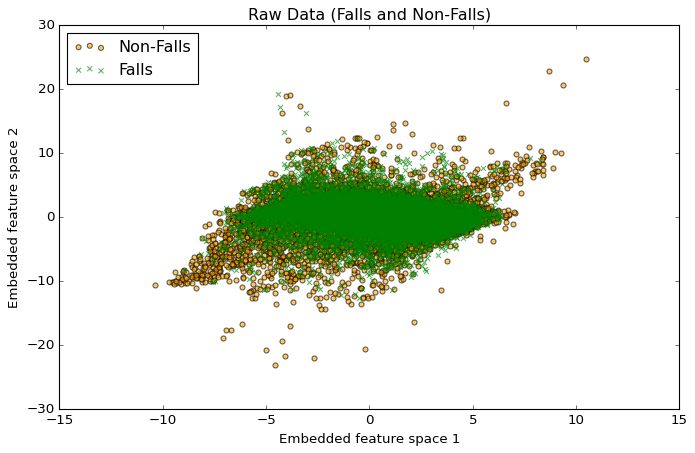

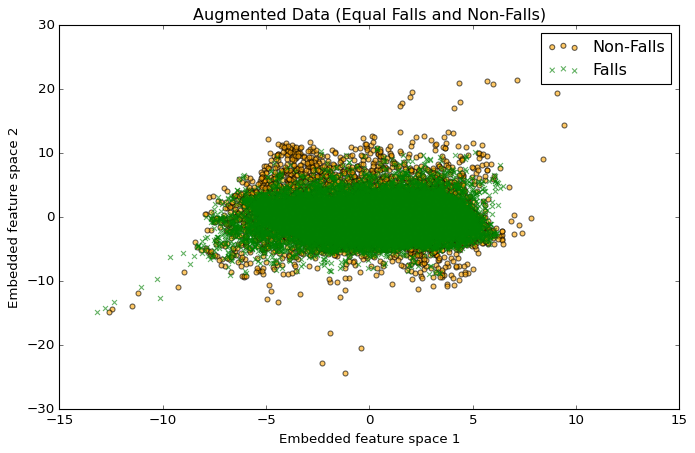

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

def reshape_data(X):
    """Reshape 3D data (samples, timesteps, features) into 2D (samples, timesteps * features)."""
    if len(X.shape) == 3:
        return X.reshape(X.shape[0], -1)  # Flatten timesteps and features
    return X

def sample_data(X, y, sample_size=500):
    """Randomly sample a subset of the data for clearer visualization."""
    if len(X) > sample_size:
        indices = np.random.choice(len(X), sample_size, replace=False)
        return X[indices], y[indices]
    return X, y

def plot_comparison(X_raw, y_raw, X_smote, y_smote, method='tsne', name="SMOTE", sample_size=500):
    """Function to plot the comparison of raw and SMOTE-resampled data."""
    X_raw = reshape_data(X_raw)
    X_smote = reshape_data(X_smote)

    # Sample the data to reduce clutter
    X_raw, y_raw = sample_data(X_raw, y_raw, sample_size)
    X_smote, y_smote = sample_data(X_smote, y_smote, sample_size)

    # Normalize the data 
    scaler = StandardScaler()
    X_raw = scaler.fit_transform(X_raw)
    X_smote = scaler.transform(X_smote)

    # dimensionality reduction 
    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
    elif method == 'pca':
        reducer = PCA(n_components=2)

    X_raw_embedded = reducer.fit_transform(X_raw)
    X_smote_embedded = reducer.fit_transform(X_smote)


    plt.figure(figsize=(10, 6), facecolor='white')

    plt.scatter(X_raw_embedded[y_raw == 0, 0], X_raw_embedded[y_raw == 0, 1],
                c='orange', label='Class 0 (Raw)', alpha=0.4, marker='+', s=10)
    plt.scatter(X_raw_embedded[y_raw == 1, 0], X_raw_embedded[y_raw == 1, 1],
                c='green', label='Class 1 (Raw)', alpha=0.4, marker='x', s=10)
    plt.scatter(X_smote_embedded[y_smote == 0, 0], X_smote_embedded[y_smote == 0, 1],
                c='blue', label=f'Class 0 ({name})', alpha=0.4, marker='+', s=10)
    plt.scatter(X_smote_embedded[y_smote == 1, 0], X_smote_embedded[y_smote == 1, 1],
                c='cyan', label=f'Class 1 ({name})', alpha=0.4, marker='x', s=10)

    plt.title(f'Raw Vs. {name}')
    plt.xlabel('Embedded feature space 1')
    plt.ylabel('Embedded feature space 2')
    plt.legend(loc='best')
    plt.show()


def plot_comparison3(X_raw, y_raw, X_smote, y_smote, method='tsne'):
    """Plot two graphs: Raw data and Augmented data with equal falls and non-falls."""
    falls_augmented = X_smote[y_smote == 1]
    non_falls_augmented = X_smote[y_smote == 0]

    # Match the size of non-falls to the # of falls
    non_falls_augmented = non_falls_augmented[:len(falls_augmented)]

    # Combine falls and non-falls 
    X_augmented = np.vstack((falls_augmented, non_falls_augmented))
    y_augmented = np.hstack((np.ones(len(falls_augmented)), np.zeros(len(falls_augmented))))
    
    plot_data(X_raw, y_raw, title='Raw Data (Falls and Non-Falls)', method=method)
    plot_data(X_augmented, y_augmented, title='Augmented Data (Equal Falls and Non-Falls)', method=method)

def plot_data(X, y, title, method='tsne'):
    """Helper function to plot falls and non-falls."""
    X = reshape_data(X)
    y = reshape_data(y)
    
    # Normalize the data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Apply dimensionality reduction
    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
    elif method == 'pca':
        reducer = PCA(n_components=2)

    X_embedded = reducer.fit_transform(X)

    # Plot falls and non-falls with different markers
    plt.figure(figsize=(10, 6), facecolor='white')
    plt.scatter(X_embedded[y == 0, 0], X_embedded[y == 0, 1], 
                c='orange', label='Non-Falls', alpha=0.6, marker='o', s=20)
    plt.scatter(X_embedded[y == 1, 0], X_embedded[y == 1, 1], 
                c='green', label='Falls', alpha=0.6, marker='x', s=20)

    plt.title(title)
    plt.xlabel('Embedded feature space 1')
    plt.ylabel('Embedded feature space 2')
    plt.legend(loc='best')
    plt.show()
    
def plot_comparison2(X_raw, y_raw, X_smote, y_smote, method='tsne', name="SMOTE"):
    """Function to plot the comparison of raw and augmented (e.g., SMOTE) fall samples only."""
    
    # Reshape data if 3D
    X_raw = reshape_data(X_raw)
    X_smote = reshape_data(X_smote)

    # Filter only fall samples (where label == 1)
    X_raw_falls = X_raw[y_raw == 1]
    X_smote_falls = X_smote[y_smote == 1]

    # Normalize the data to improve t-SNE/PCA performance
    scaler = StandardScaler()
    X_raw_falls = scaler.fit_transform(X_raw_falls)
    X_smote_falls = scaler.transform(X_smote_falls)

    # Apply dimensionality reduction (t-SNE or PCA)
    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
    elif method == 'pca':
        reducer = PCA(n_components=2)

    X_raw_embedded = reducer.fit_transform(X_raw_falls)
    X_smote_embedded = reducer.fit_transform(X_smote_falls)

    # Plotting with improved visualization
    plt.figure(figsize=(10, 6), facecolor='white')  # Set background to white

    # Plot Raw Fall Samples (single color)
    plt.scatter(X_raw_embedded[:, 0], X_raw_embedded[:, 1], 
                c='green', label='Raw Fall Data', alpha=0.5, marker='o', s=20)

    # Plot Augmented Fall Samples (single color)
    plt.scatter(X_smote_embedded[:, 0], X_smote_embedded[:, 1], 
                c='blue', label=f'{name} Fall Data', alpha=0.5, marker='o', s=20)

    plt.title(f'Raw Vs. {name} (Fall Samples Only)')
    plt.xlabel('Embedded feature space 1')
    plt.ylabel('Embedded feature space 2')
    plt.legend(loc='best')
    plt.show()

# X_t = final_df_ambient.drop('class', axis=1)
# y_t = final_df_ambient['class']

windows_t, labels_t = create_sliding_windows_normal(final_df_ambient, window_size=11, step_size=1)
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(
    windows_t, labels_t, test_size=0.2, random_state=42
)

X_train_resampled_t, y_train_resampled_t = apply_smote(X_train_t, y_train_t)
plot_comparison3(X_train_t, y_train_t, X_train_resampled_t, y_train_resampled_t, method='pca')

# oversampling technique: SMOTE
## using final_df_ambient -> with aggregated ambient feature

Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)

==================== Training Set Before Augmentation ====================
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 14038 samples (72.51%)
Class 1: 5322 samples (27.49%)
Data after SMOTE: 28076 samples

==================== Training Set After apply_smote ====================
Dataset shape: (28076, 11, 9)
Labels shape: (28076,)

Class Distribution:
-----------------
Class 0: 14038 samples (50.00%)
Class 1: 14038 samples (50.00%)

Fold 1/5
Epoch 1/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.5810 - loss: 0.6733 - val_accuracy: 0.6366 - val_loss: 0.6409
Epoch 2/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6454 - loss: 0.6339 - val_accuracy: 0.6599 - val_loss: 0.6180
Epoch 3/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6725 - loss: 0.6078 - val_accuracy: 0.6797 - val_loss: 0.5993
Epoch 4/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 5s

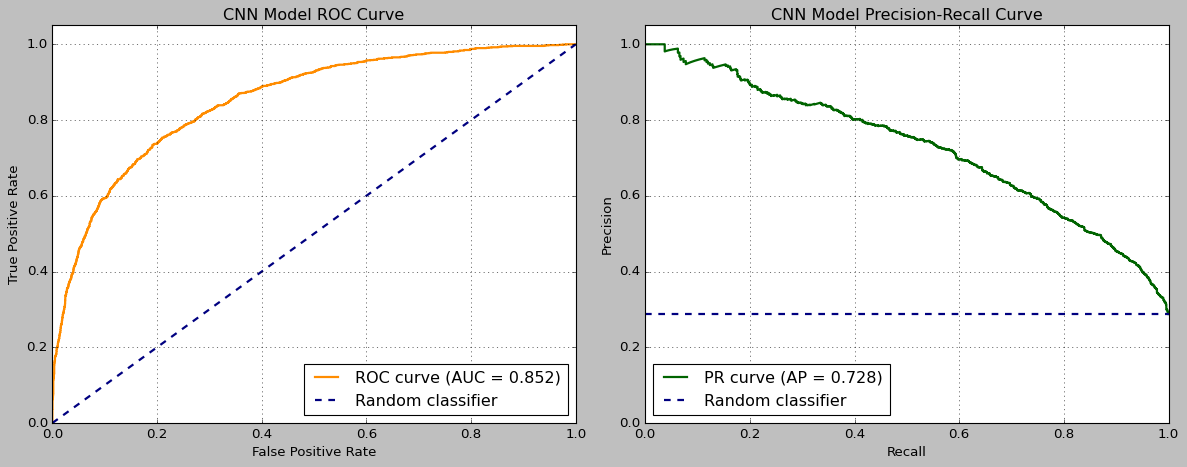

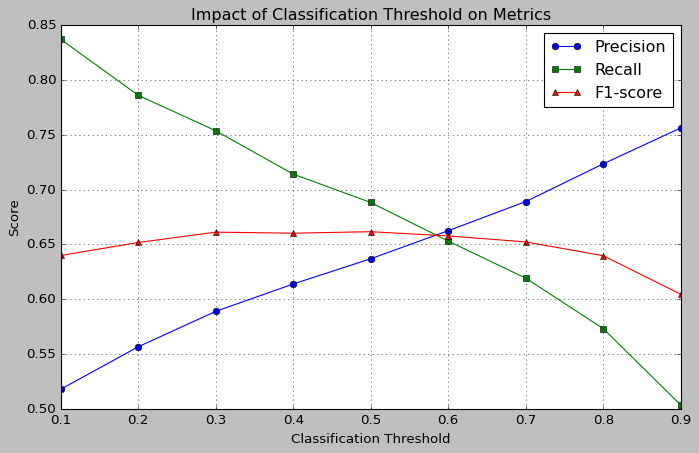


    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): 0.8519

    2. Precision-Recall Analysis:
    - Average Precision (AP): 0.7280

    3. Threshold Analysis:
    Optimal threshold based on F1-score: 0.50
    
    Performance at different thresholds:
    
   Threshold 0.1: Precision=0.518, Recall=0.837, F1=0.640
   Threshold 0.2: Precision=0.557, Recall=0.786, F1=0.652
   Threshold 0.3: Precision=0.589, Recall=0.754, F1=0.661
   Threshold 0.4: Precision=0.614, Recall=0.714, F1=0.660
   Threshold 0.5: Precision=0.637, Recall=0.688, F1=0.662
   Threshold 0.6: Precision=0.663, Recall=0.653, F1=0.658
   Threshold 0.7: Precision=0.689, Recall=0.619, F1=0.652
   Threshold 0.8: Precision=0.723, Recall=0.573, F1=0.640
   Threshold 0.9: Precision=0.756, Recall=0.504, F1=0.605
    
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Cross-Validation Results:
Accuracy: 0.8603 ± 0.0118
Precision: 0.8458 ± 0.0226
Recall: 0.8826 ± 0.0192
F1: 0.8634 ± 0.0100

Test Set

In [19]:
cv_scores_1, test_scores_1, best_lstm_model_1, history_lstm_model_1 = kfold_model_performance(
    final_df_ambient, build_model_fn=build_lstm_model_l2, augmentation_fn=apply_smote, 
    window_size=11, step_size=1
)

Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)

==================== Training Set Before Augmentation ====================
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 14038 samples (72.51%)
Class 1: 5322 samples (27.49%)
Data after SMOTE: 28076 samples

==================== Training Set After apply_smote ====================
Dataset shape: (28076, 11, 9)
Labels shape: (28076,)

Class Distribution:
-----------------
Class 0: 14038 samples (50.00%)
Class 1: 14038 samples (50.00%)

Fold 1/5
Epoch 1/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.5881 - loss: 0.6735 - val_accuracy: 0.6357 - val_loss: 0.6410
Epoch 2/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.6479 - loss: 0.6327 - val_accuracy: 0.6633 - val_loss: 0.6169
Epoch 3/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.6761 - loss: 0.6055 - val_accuracy: 0.6798 - val_loss: 0.5950
Epoch 4/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 7

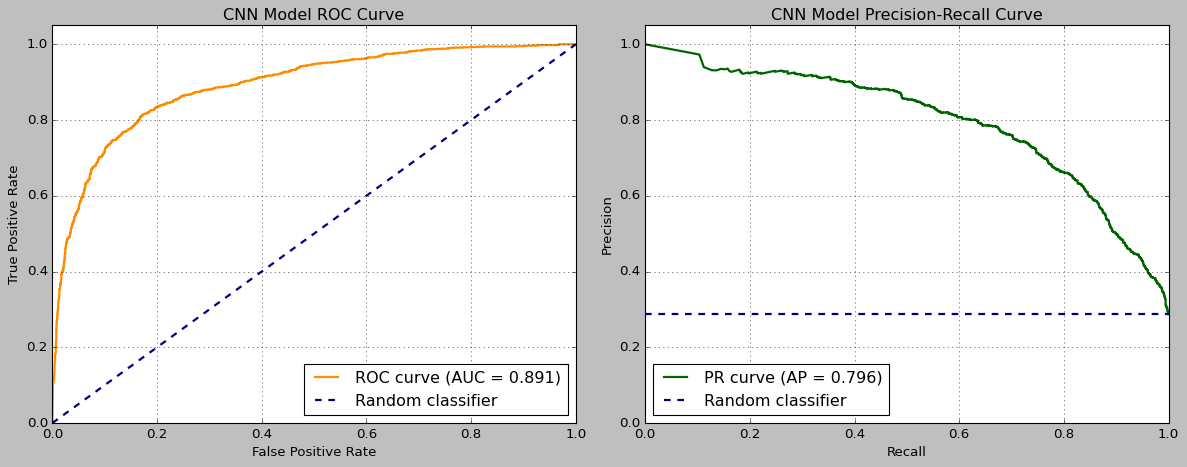

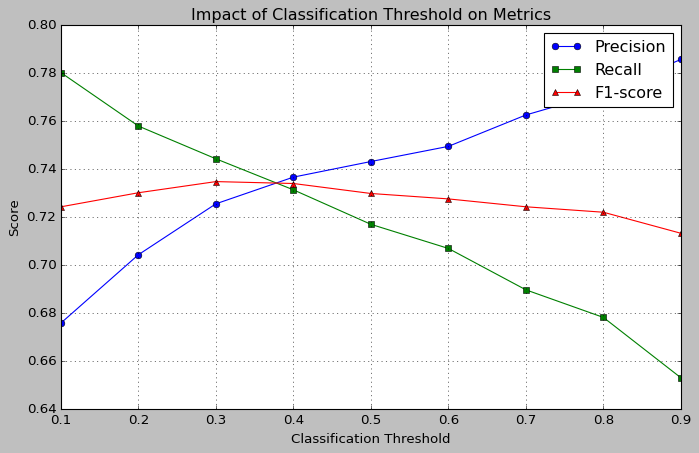


    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): 0.8910

    2. Precision-Recall Analysis:
    - Average Precision (AP): 0.7963

    3. Threshold Analysis:
    Optimal threshold based on F1-score: 0.30
    
    Performance at different thresholds:
    
   Threshold 0.1: Precision=0.676, Recall=0.780, F1=0.724
   Threshold 0.2: Precision=0.704, Recall=0.758, F1=0.730
   Threshold 0.3: Precision=0.725, Recall=0.744, F1=0.735
   Threshold 0.4: Precision=0.737, Recall=0.731, F1=0.734
   Threshold 0.5: Precision=0.743, Recall=0.717, F1=0.730
   Threshold 0.6: Precision=0.749, Recall=0.707, F1=0.728
   Threshold 0.7: Precision=0.763, Recall=0.690, F1=0.724
   Threshold 0.8: Precision=0.772, Recall=0.678, F1=0.722
   Threshold 0.9: Precision=0.786, Recall=0.653, F1=0.713
    
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Cross-Validation Results:
Accuracy: 0.9067 ± 0.0058
Precision: 0.8932 ± 0.0038
Recall: 0.9239 ± 0.0115
F1: 0.9083 ± 0.0061

Test Set

In [6]:
# second model with more units
# no early stoppping (updated)
cv_scores_1, test_scores_1, best_lstm_model_1, history_lstm_model_1 = kfold_model_performance(
    final_df_ambient, build_model_fn=build_lstm_model_2, augmentation_fn=apply_smote, 
    window_size=11, step_size=1
)
# build_lstm_model_2 performs better than build_lstm_model_l2

In [ ]:
# cv_scores_1s, test_scores_1s, best_lstm_model_1s, history_lstm_model_1s = kfold_model_performance_strat(
#     final_df_ambient, build_model_fn=build_lstm_model_2, augmentation_fn=apply_smote, 
#     window_size=11, step_size=1
# )

Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)

==================== Training Set Before Augmentation ====================
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 14038 samples (72.51%)
Class 1: 5322 samples (27.49%)
Data after SMOTE: 28076 samples

==================== Training Set After apply_smote ====================
Dataset shape: (28076, 11, 9)
Labels shape: (28076,)

Class Distribution:
-----------------
Class 0: 14038 samples (50.00%)
Class 1: 14038 samples (50.00%)

Fold 1/5
Epoch 1/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.5873 - loss: 0.6759 - val_accuracy: 0.6344 - val_loss: 0.6493
Epoch 2/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.6501 - loss: 0.6357 - val_accuracy: 0.6619 - val_loss: 0.6213
Epoch 3/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.6818 - loss: 0.6063 - val_accuracy: 0.6850 - val_loss: 0.5911
Epoch 4/100
702/702 ━━━━━━━━━━━━━━━━━━

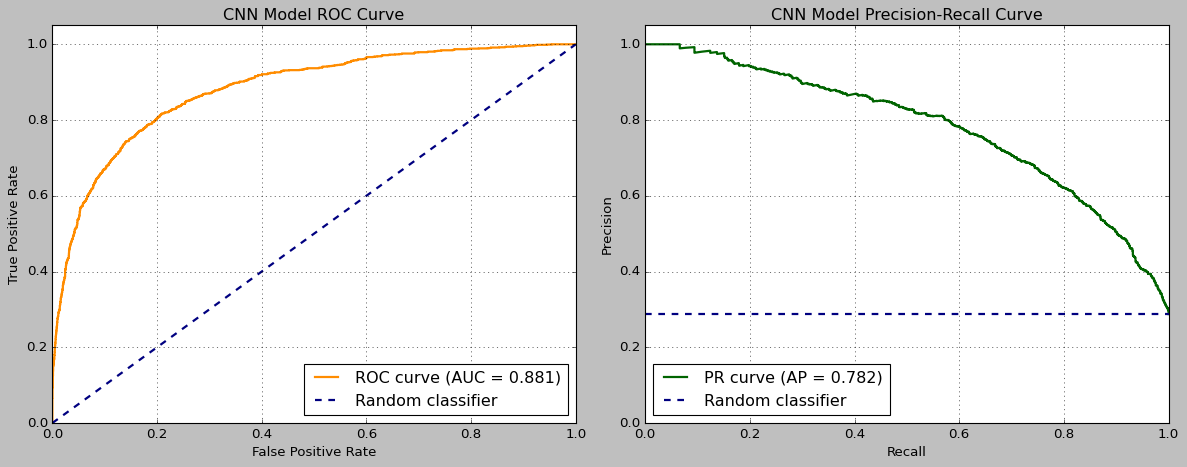

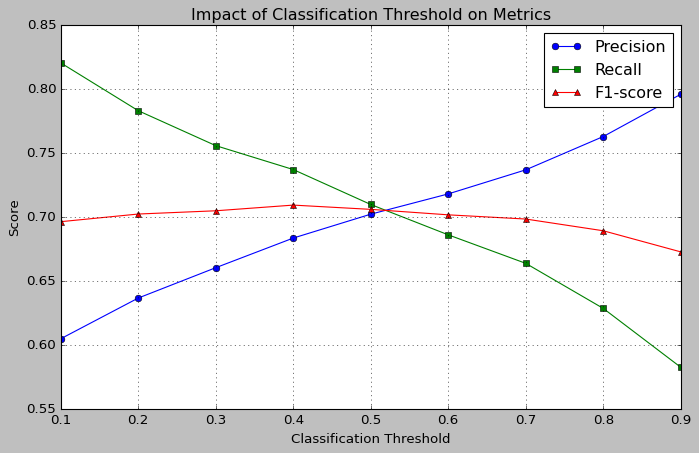


    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): 0.8805

    2. Precision-Recall Analysis:
    - Average Precision (AP): 0.7821

    3. Threshold Analysis:
    Optimal threshold based on F1-score: 0.40
    
    Performance at different thresholds:
    
   Threshold 0.1: Precision=0.605, Recall=0.820, F1=0.696
   Threshold 0.2: Precision=0.637, Recall=0.783, F1=0.702
   Threshold 0.3: Precision=0.660, Recall=0.756, F1=0.705
   Threshold 0.4: Precision=0.684, Recall=0.737, F1=0.709
   Threshold 0.5: Precision=0.702, Recall=0.710, F1=0.706
   Threshold 0.6: Precision=0.718, Recall=0.686, F1=0.702
   Threshold 0.7: Precision=0.737, Recall=0.664, F1=0.698
   Threshold 0.8: Precision=0.763, Recall=0.629, F1=0.689
   Threshold 0.9: Precision=0.796, Recall=0.583, F1=0.673
    
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Cross-Validation Results:
Accuracy: 0.8896 ± 0.0089
Precision: 0.8712 ± 0.0140
Recall: 0.9147 ± 0.0103
F1: 0.8924 ± 0.0082

Test Set

In [37]:
# third model with more units
# cv_scores_1, test_scores_1, best_lstm_model_1, history_lstm_model_1 = kfold_model_performance(
#     final_df_ambient, build_model_fn=build_lstm_model_3, augmentation_fn=apply_smote, 
#     window_size=11, step_size=1
# )

## Oversampling technique 2: ROS
### final_df_ambient
### build_lstm_model_l2

Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)

==================== Training Set Before Augmentation ====================
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 13989 samples (72.26%)
Class 1: 5371 samples (27.74%)
Data after ROS: 27978 samples

==================== Training Set After apply_ros ====================
Dataset shape: (27978, 11, 9)
Labels shape: (27978,)

Class Distribution:
-----------------
Class 0: 13989 samples (50.00%)
Class 1: 13989 samples (50.00%)

Fold 1/5
Epoch 1/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5959 - loss: 0.6693 - val_accuracy: 0.6583 - val_loss: 0.6286
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6524 - loss: 0.6294 - val_accuracy: 0.6716 - val_loss: 0.6073
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6751 - loss: 0.6088 - val_accuracy: 0.6757 - val_loss: 0.5997
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/

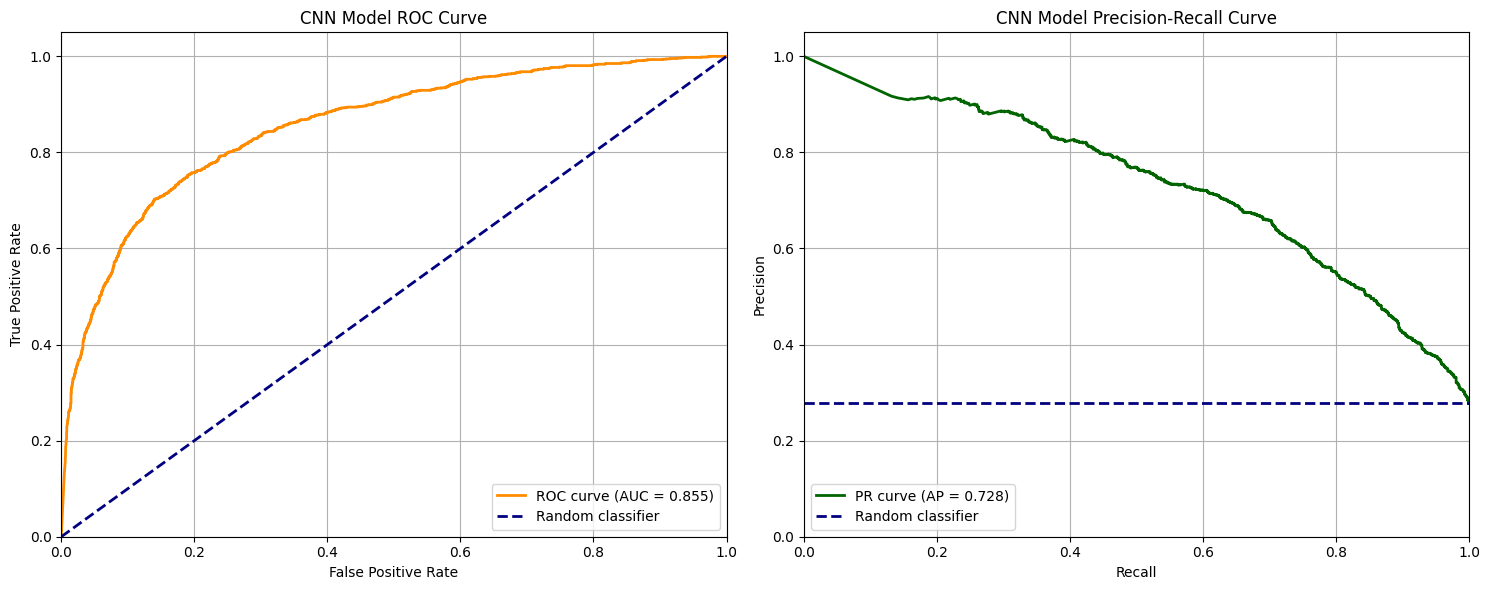

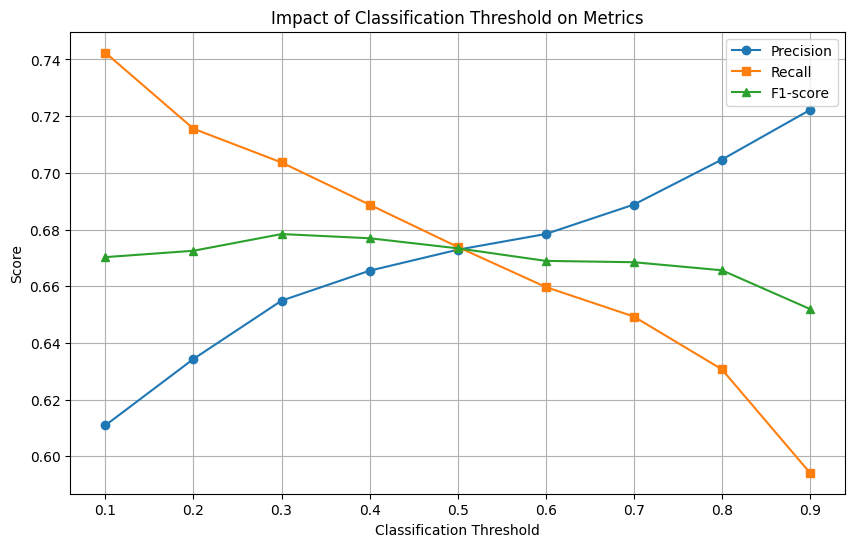


    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): 0.8551

    2. Precision-Recall Analysis:
    - Average Precision (AP): 0.7278

    3. Threshold Analysis:
    Optimal threshold based on F1-score: 0.30
    
    Performance at different thresholds:
    
   Threshold 0.1: Precision=0.611, Recall=0.742, F1=0.670
   Threshold 0.2: Precision=0.634, Recall=0.716, F1=0.672
   Threshold 0.3: Precision=0.655, Recall=0.704, F1=0.678
   Threshold 0.4: Precision=0.665, Recall=0.689, F1=0.677
   Threshold 0.5: Precision=0.673, Recall=0.674, F1=0.673
   Threshold 0.6: Precision=0.678, Recall=0.660, F1=0.669
   Threshold 0.7: Precision=0.689, Recall=0.649, F1=0.668
   Threshold 0.8: Precision=0.705, Recall=0.631, F1=0.666
   Threshold 0.9: Precision=0.722, Recall=0.594, F1=0.652
    
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Cross-Validation Results:
Accuracy: 0.9044 ± 0.0053
Precision: 0.8730 ± 0.0127
Recall: 0.9468 ± 0.0064
F1: 0.9083 ± 0.0041

Test Set

In [10]:
cv_scores_2, test_scores_2, best_lstm_model_2, history_lstm_model_2 = kfold_model_performance(
    final_df_ambient, build_model_fn=build_lstm_model_l2, augmentation_fn=apply_ros, 
    window_size=11, step_size=1
)

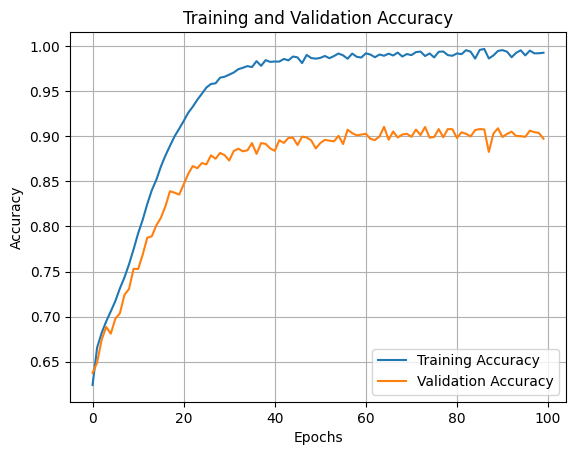

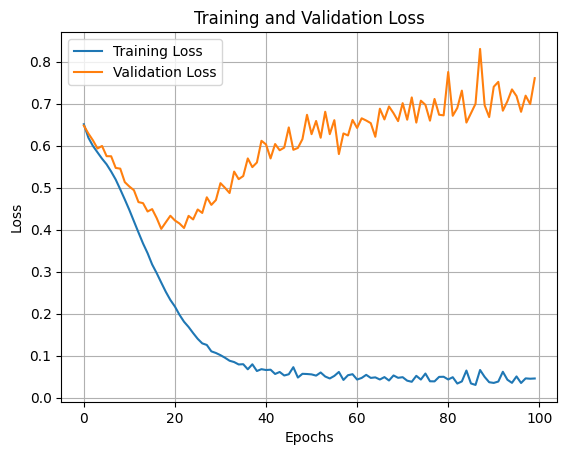

In [11]:
def plot_accuracy(history):
    plt.figure()
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
def plot_loss(history):
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
plt.style.use('default')

plot_accuracy(history_lstm_model_2)
plot_loss(history_lstm_model_2)

## Oversampling technique: ADASYN

Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)

==================== Training Set Before Augmentation ====================
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 14038 samples (72.51%)
Class 1: 5322 samples (27.49%)
Data after ADASYN: 26965 samples

==================== Training Set After apply_adasyn ====================
Dataset shape: (26965, 11, 9)
Labels shape: (26965,)

Class Distribution:
-----------------
Class 0: 14038 samples (52.06%)
Class 1: 12927 samples (47.94%)

Fold 1/5
Epoch 1/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.5683 - loss: 0.6800 - val_accuracy: 0.6288 - val_loss: 0.6490
Epoch 2/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6287 - loss: 0.6446 - val_accuracy: 0.6330 - val_loss: 0.6358
Epoch 3/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6550 - loss: 0.6213 - val_accuracy: 0.6544 - val_loss: 0.6237
Epoch 4/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 

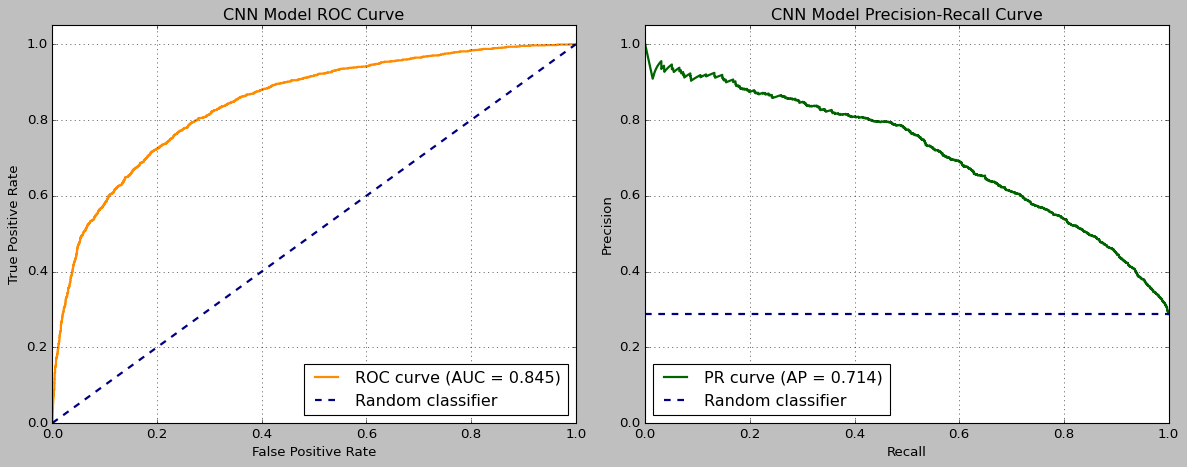

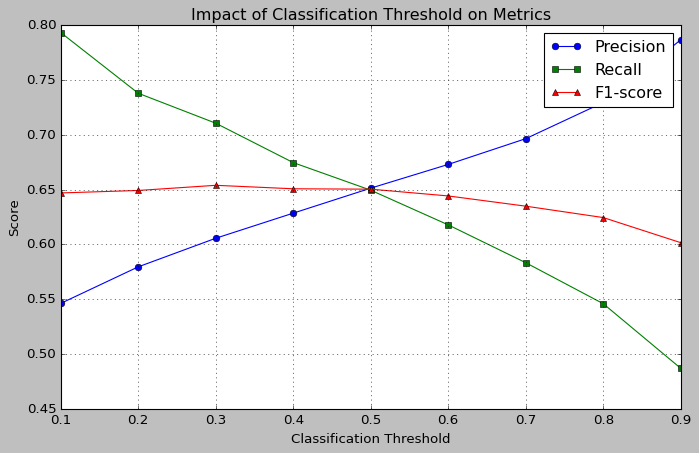


    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): 0.8448

    2. Precision-Recall Analysis:
    - Average Precision (AP): 0.7142

    3. Threshold Analysis:
    Optimal threshold based on F1-score: 0.30
    
    Performance at different thresholds:
    
   Threshold 0.1: Precision=0.546, Recall=0.793, F1=0.647
   Threshold 0.2: Precision=0.580, Recall=0.738, F1=0.649
   Threshold 0.3: Precision=0.606, Recall=0.710, F1=0.654
   Threshold 0.4: Precision=0.629, Recall=0.675, F1=0.651
   Threshold 0.5: Precision=0.651, Recall=0.649, F1=0.650
   Threshold 0.6: Precision=0.673, Recall=0.618, F1=0.644
   Threshold 0.7: Precision=0.696, Recall=0.583, F1=0.635
   Threshold 0.8: Precision=0.729, Recall=0.546, F1=0.624
   Threshold 0.9: Precision=0.787, Recall=0.487, F1=0.602
    
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Cross-Validation Results:
Accuracy: 0.8484 ± 0.0131
Precision: 0.8274 ± 0.0181
Recall: 0.8645 ± 0.0165
F1: 0.8454 ± 0.0128

Test Set

In [33]:
# cv_scores_1, test_scores_1, best_lstm_model_1, history_lstm_model_1 = kfold_model_performance(
#     final_df_clean, build_model_fn=build_lstm_model_l2, augmentation_fn=apply_smote, 
#     window_size=11, step_size=1
# )

# ROS 
cv_scores_1, test_scores_1, best_lstm_model_1, history_lstm_model_1 = kfold_model_performance(
    final_df_ambient, build_model_fn=build_lstm_model_l2, augmentation_fn=apply_adasyn, 
    window_size=11, step_size=1
)

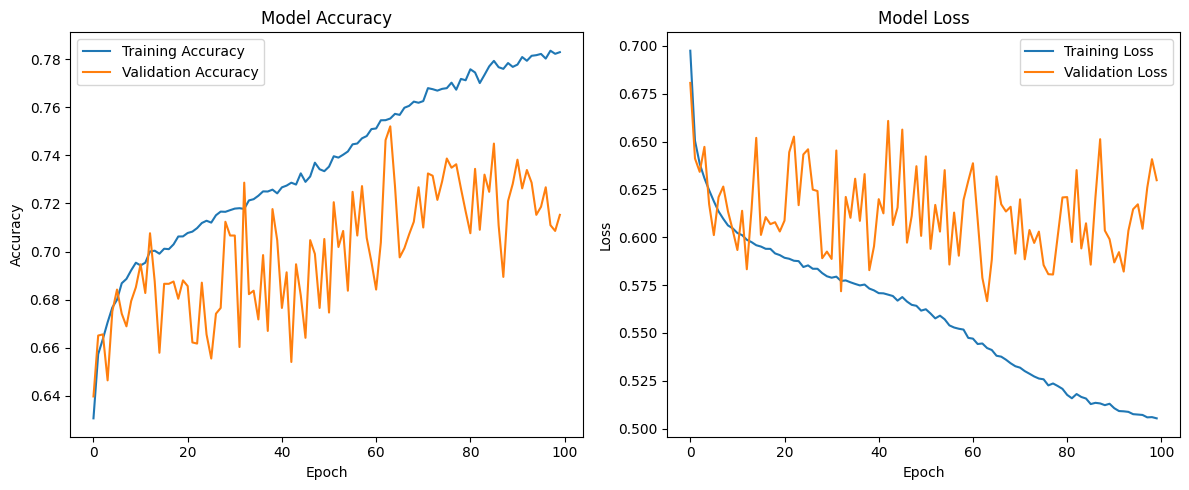

In [11]:

def plot_performance(history):
    # plot training & validation accuracy values
    plt.figure(figsize=(12, 5))

    # accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
plot_performance(lstm_model_history)

## Oversampling technique 3: Mu-Sigma

Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)

==================== Training Set Before Augmentation ====================
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 14038 samples (72.51%)
Class 1: 5322 samples (27.49%)

==================== Training Set After apply_mu_sigma ====================
Dataset shape: (58080, 11, 9)
Labels shape: (58080,)

Class Distribution:
-----------------
Class 0: 42114 samples (72.51%)
Class 1: 15966 samples (27.49%)

Fold 1/5
Epoch 1/100
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.7231 - loss: 0.5778 - val_accuracy: 0.7277 - val_loss: 0.5609
Epoch 2/100
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7351 - loss: 0.5457 - val_accuracy: 0.7361 - val_loss: 0.5469
Epoch 3/100
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.7416 - loss: 0.5365 - val_accuracy: 0.7418 - val_loss: 0.5389
Epoch 4/100
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accurac

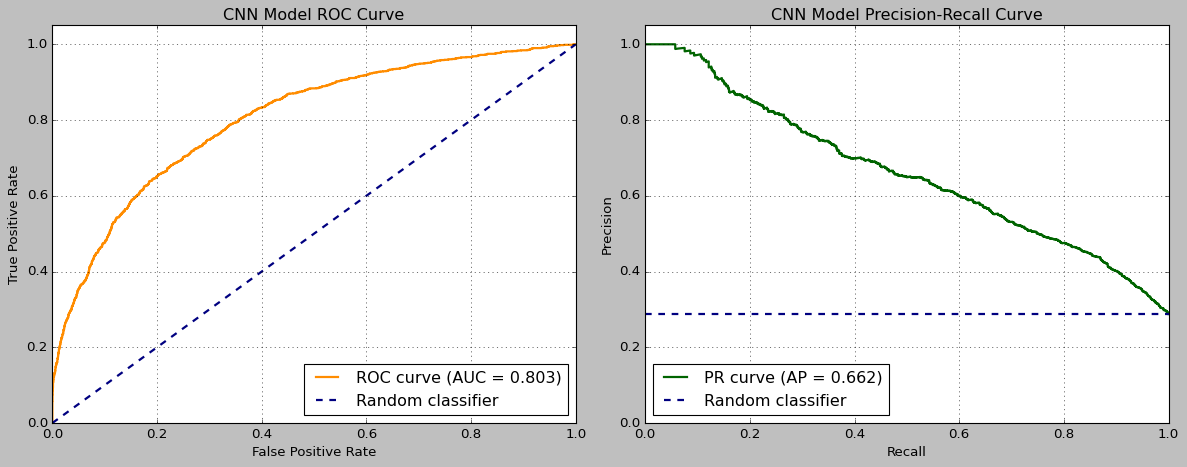

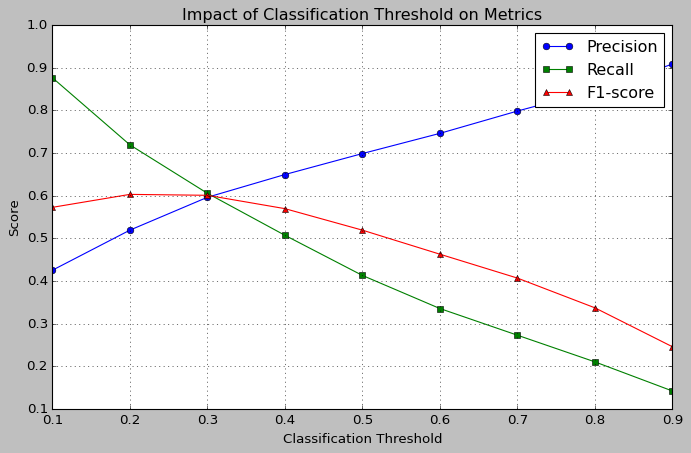


    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): 0.8030

    2. Precision-Recall Analysis:
    - Average Precision (AP): 0.6618

    3. Threshold Analysis:
    Optimal threshold based on F1-score: 0.20
    
    Performance at different thresholds:
    
   Threshold 0.1: Precision=0.425, Recall=0.876, F1=0.573
   Threshold 0.2: Precision=0.519, Recall=0.719, F1=0.603
   Threshold 0.3: Precision=0.596, Recall=0.606, F1=0.601
   Threshold 0.4: Precision=0.649, Recall=0.507, F1=0.570
   Threshold 0.5: Precision=0.699, Recall=0.413, F1=0.519
   Threshold 0.6: Precision=0.746, Recall=0.335, F1=0.463
   Threshold 0.7: Precision=0.798, Recall=0.273, F1=0.407
   Threshold 0.8: Precision=0.847, Recall=0.210, F1=0.337
   Threshold 0.9: Precision=0.908, Recall=0.142, F1=0.246
    
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Cross-Validation Results:
Accuracy: 0.7581 ± 0.0042
Precision: 0.5977 ± 0.0147
Recall: 0.3681 ± 0.0173
F1: 0.4553 ± 0.0131

Test Set

In [34]:
# cv_scores_1, test_scores_1, best_lstm_model_1, history_lstm_model_1 = kfold_model_performance(
#     final_df_ambient, build_model_fn=build_lstm_model_l2, augmentation_fn=apply_mu_sigma, 
#     window_size=11, step_size=1
# )


def apply_mu_sigma_new(X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    # Identify the minority and majority class based on class distribution
    class_labels, class_counts = np.unique(y, return_counts=True)
    minority_class = class_labels[np.argmin(class_counts)]
    majority_class = class_labels[np.argmax(class_counts)]

    # Split the original data into majority and minority class subsets
    X_majority = X[y == majority_class]
    X_minority = X[y == minority_class]

    # Mu-Sigma augmentation on the minority class
    n_minority_samples = X_minority.shape[0]
    n_timesteps, n_features = X.shape[1], X.shape[2]

    # Initialize array for augmented minority data
    X_minority_augmented = np.zeros((n_minority_samples * 3, n_timesteps, n_features))

    for i in range(n_minority_samples):
        sample = X_minority[i]
        sigma = np.std(sample, axis=0, keepdims=True)  # Feature-wise standard deviation
        noise = np.random.normal(loc=0, scale=sigma, size=sample.shape)

        # Add original, +noise, and -noise versions to the augmented data
        X_minority_augmented[i] = sample
        X_minority_augmented[n_minority_samples + i] = sample + noise
        X_minority_augmented[2 * n_minority_samples + i] = sample - noise

    # Create labels for the augmented minority data
    y_minority_augmented = np.full(X_minority_augmented.shape[0], minority_class)

    # Combine the augmented minority class with the majority class
    X_augmented = np.vstack((X_majority, X_minority_augmented))
    y_augmented = np.concatenate((np.full(X_majority.shape[0], majority_class), y_minority_augmented))

    # Shuffle the combined dataset
    shuffle_idx = np.random.permutation(len(X_augmented))
    X_augmented = X_augmented[shuffle_idx]
    y_augmented = y_augmented[shuffle_idx]
    
    return X_augmented, y_augmented

cv_scores_ms2, test_scores_ms2, best_cnn_model_ms2, history_model_ms2 = kfold_model_performance(
    final_df_ambient, build_model_fn=build_resnet, augmentation_fn=apply_mu_sigma_new, 
    window_size=11, step_size=1
)


# gan 

Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)

==================== Training Set Before Augmentation ====================
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 13989 samples (72.26%)
Class 1: 5371 samples (27.74%)
Epoch [0/500] | D Loss: 1.3827 | G Loss: 0.6666
Epoch [100/500] | D Loss: 1.3134 | G Loss: 0.6888
Epoch [200/500] | D Loss: 1.2932 | G Loss: 0.6873
Epoch [300/500] | D Loss: 1.2035 | G Loss: 0.7078
Epoch [400/500] | D Loss: 1.1253 | G Loss: 0.7281

==================== Training Set After apply_gan_augmentation ====================
Dataset shape: (27978, 11, 9)
Labels shape: (27978,)

Class Distribution:
-----------------
Class 0.0: 13989 samples (50.00%)
Class 1.0: 13989 samples (50.00%)

Fold 1/5
Epoch 1/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7809 - loss: 0.4597 - val_accuracy: 0.8159 - val_loss: 0.3821
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.814

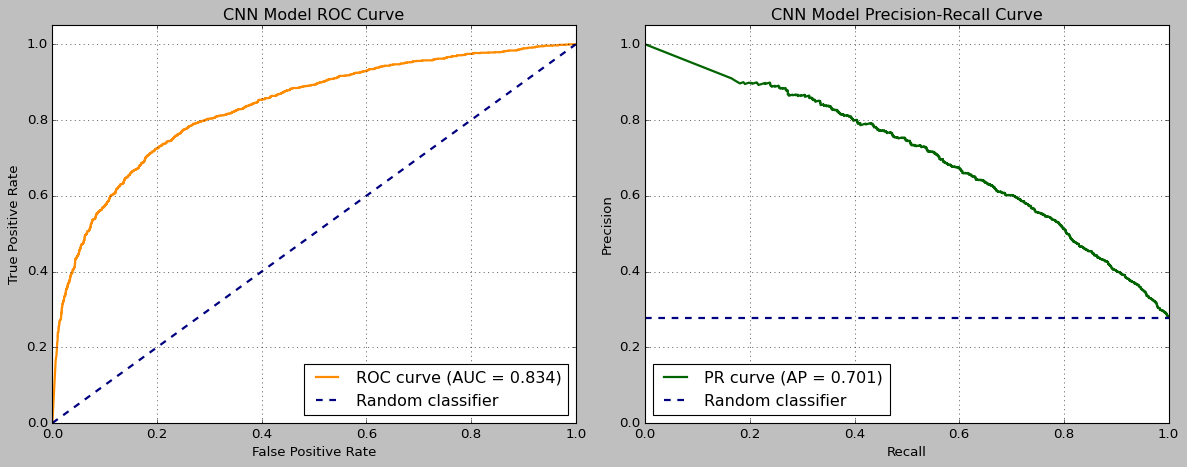

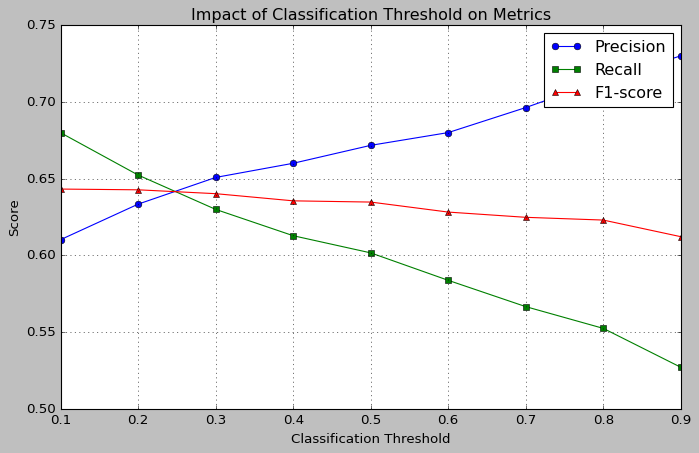


    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): 0.8342

    2. Precision-Recall Analysis:
    - Average Precision (AP): 0.7014

    3. Threshold Analysis:
    Optimal threshold based on F1-score: 0.10
    
    Performance at different thresholds:
    
   Threshold 0.1: Precision=0.610, Recall=0.680, F1=0.643
   Threshold 0.2: Precision=0.633, Recall=0.652, F1=0.643
   Threshold 0.3: Precision=0.651, Recall=0.630, F1=0.640
   Threshold 0.4: Precision=0.660, Recall=0.613, F1=0.636
   Threshold 0.5: Precision=0.672, Recall=0.602, F1=0.635
   Threshold 0.6: Precision=0.680, Recall=0.584, F1=0.628
   Threshold 0.7: Precision=0.696, Recall=0.567, F1=0.625
   Threshold 0.8: Precision=0.714, Recall=0.552, F1=0.623
   Threshold 0.9: Precision=0.730, Recall=0.527, F1=0.612
    
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Cross-Validation Results:
Accuracy: 0.8710 ± 0.0068
Precision: 0.8817 ± 0.0098
Recall: 0.8572 ± 0.0065
F1: 0.8692 ± 0.0066

Test Set

In [29]:
import torch
import torch.nn as nn


cv_scores_g, test_scores_g, best_lstm_model_g, history_lstm_model_g = kfold_model_performance(
    final_df_ambient, 
    build_model_fn=build_lstm_model_l2, augmentation_fn=apply_gan_augmentation, 
    window_size=11, step_size=1
)

Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)

==================== Training Set Before Augmentation ====================
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 13989 samples (72.26%)
Class 1: 5371 samples (27.74%)

==================== Training set: NO Sampling ====================
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 13989 samples (72.26%)
Class 1: 5371 samples (27.74%)

Fold 1/5
Epoch 1/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7186 - loss: 0.5942 - val_accuracy: 0.7255 - val_loss: 0.5583
Epoch 2/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7344 - loss: 0.5497 - val_accuracy: 0.7270 - val_loss: 0.5510
Epoch 3/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7354 - loss: 0.5432 - val_accuracy: 0.7280 - val_loss: 0.5468
Epoch 4/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7447 - loss: 0.

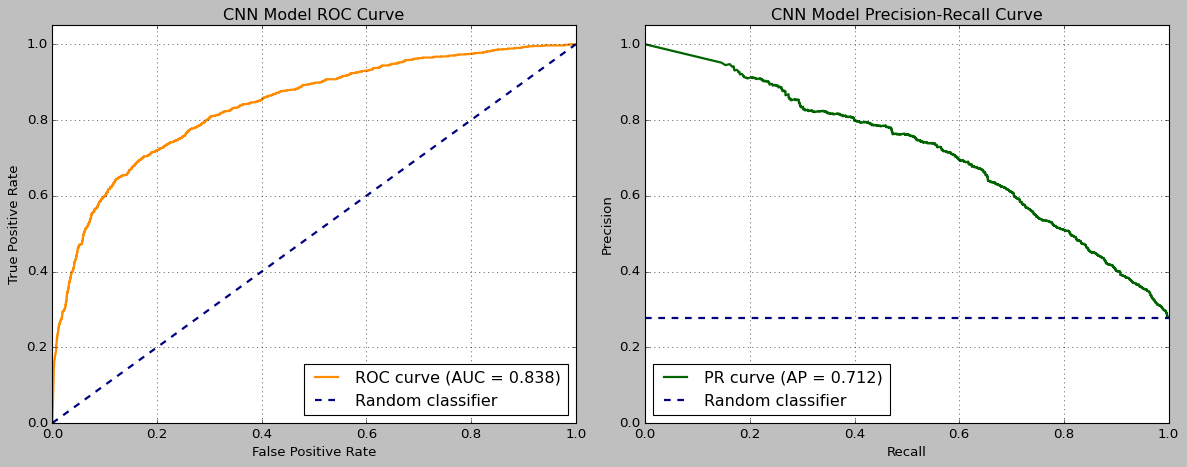

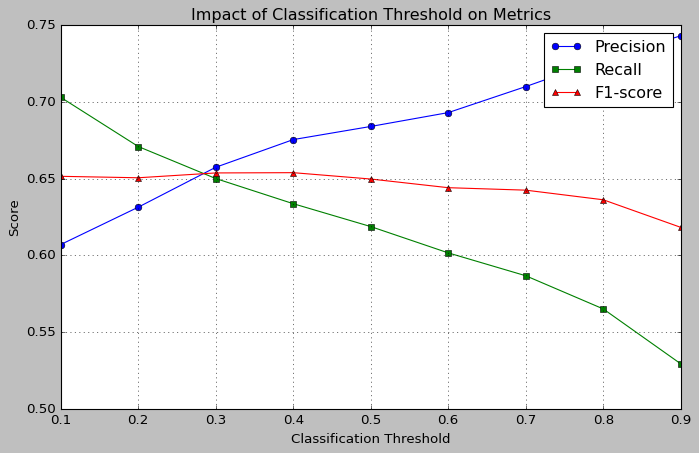


    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): 0.8377

    2. Precision-Recall Analysis:
    - Average Precision (AP): 0.7124

    3. Threshold Analysis:
    Optimal threshold based on F1-score: 0.40
    
    Performance at different thresholds:
    
   Threshold 0.1: Precision=0.607, Recall=0.703, F1=0.651
   Threshold 0.2: Precision=0.631, Recall=0.671, F1=0.651
   Threshold 0.3: Precision=0.657, Recall=0.650, F1=0.654
   Threshold 0.4: Precision=0.675, Recall=0.634, F1=0.654
   Threshold 0.5: Precision=0.684, Recall=0.619, F1=0.650
   Threshold 0.6: Precision=0.693, Recall=0.602, F1=0.644
   Threshold 0.7: Precision=0.710, Recall=0.587, F1=0.642
   Threshold 0.8: Precision=0.728, Recall=0.565, F1=0.636
   Threshold 0.9: Precision=0.743, Recall=0.529, F1=0.618
    
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Cross-Validation Results:
Accuracy: 0.8103 ± 0.0061
Precision: 0.6620 ± 0.0113
Recall: 0.6463 ± 0.0221
F1: 0.6538 ± 0.0138

Test Set

In [30]:
# no sampling 
cv_scores_no, test_scores_no, best_lstm_model_no, history_lstm_model_no = kfold_model_performance(
    final_df_ambient, 
    build_model_fn=build_lstm_model_l2, augmentation_fn=None, 
    window_size=11, step_size=1
)

In [ ]:
lstm_model_3, lstm_model_3_history = preprocess_and_train(final_df_clean, 
                                                    build_model_fn=build_lstm_model_l2,
                                                    augmentation_fn=apply_smote)

In [ ]:
lstm_model_4, lstm_model_4_history = preprocess_and_train(final_df, 
                                                    build_model_fn=build_lstm_model_4,
                                                    augmentation_fn=apply_smote)
plot_performance(lstm_model_4_history)

NameError: name 'build_lstm_model_4' is not defined